# Checking out the dataset

In [9]:
import cv2 as cv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

atis_intent_train = pd.read_csv('/home/ubuntu/adithya/temp/EAMLA/Natural Language Processing/atis_intents_train.csv', names=['label','text']).sort_values(by='label')
atis_intent_test = pd.read_csv('/home/ubuntu/adithya/temp/EAMLA/Natural Language Processing/atis_intents_test.csv', names=['label','text']).sort_values(by='label')

In [10]:
atis_intent_train, atis_intent_val = train_test_split(atis_intent_train, test_size = 0.1, random_state = 200)

In [11]:
def oversample_data(df):
    largest_rep = max(df['label'].value_counts().tolist())
    other_entries = df[df['label'] != 'atis_flight']

    labels = other_entries['label'].unique().tolist()
    for label in labels:
        class_entries = df[df['label'] == label]
        num = len(class_entries)
        scale_factor = largest_rep // num
        print(num)
        print(scale_factor)
        df = df.append([class_entries]*scale_factor)
    return df

def undersample_data(df):
    largest_set = df[df['label'] == 'atis_flight']
    other_entries = df[df['label'] != 'atis_flight']
    sub = largest_set.sample(n=500,random_state=1)
    print(sub)
    other_entries = other_entries.append([sub])
    return other_entries

In [6]:
# other_labels = atis_intent_train[atis_intent_train['label'] != 'atis_flight']
# atis_intent_train = atis_intent_train.append([other_labels]*5)
atis_intent_train = oversample_data(atis_intent_train)

225
2
47
10
371
1
143
3
51
9
76
6
130
3


/tmp/ipykernel_1001637/3272206853.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append([class_entries]*scale_factor)
/tmp/ipykernel_1001637/3272206853.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append([class_entries]*scale_factor)
/tmp/ipykernel_1001637/3272206853.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append([class_entries]*scale_factor)
/tmp/ipykernel_1001637/3272206853.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append([class_entries]*scale_factor)
/tmp/ipykernel_1001637/3272206853.py:12: FutureWarning: The frame.append method is deprecated and will be removed fr

In [12]:
atis_intent_train

,label,text
4683,atis_flight,what is the earliest flight from boston to at...
3111,atis_ground_service,what is the ground transportation from boston...
3844,atis_flight,give me the flights from boston to san franci...
1856,atis_quantity,how many of delta's night flights are first c...
2919,atis_flight,what are your flights from denver to baltimore
...,...,...
2662,atis_flight,on monday show me flights from baltimore to d...
1249,atis_flight,show me flights between new york city and las...
2092,atis_airline,show me airline abbreviations
4375,atis_ground_service,what's the ground transportation from oakland...


In [13]:
# Checkout distribution per class and plot
import seaborn as sns
import matplotlib.pyplot as plt
def show_dist(df:pd.DataFrame):
    sns.displot(df,x=df['label'])
    plt.xticks(rotation=90)

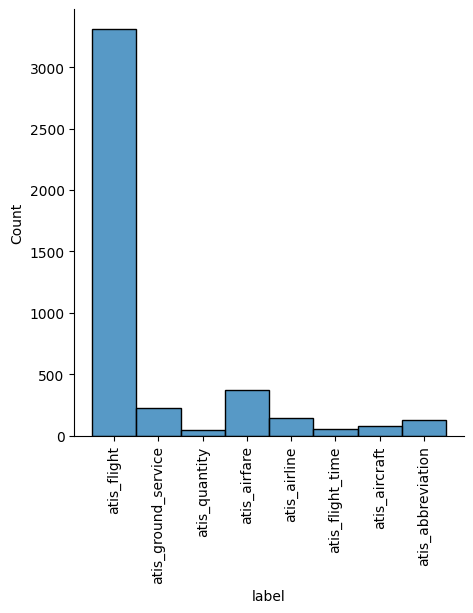

In [14]:
show_dist(atis_intent_train)

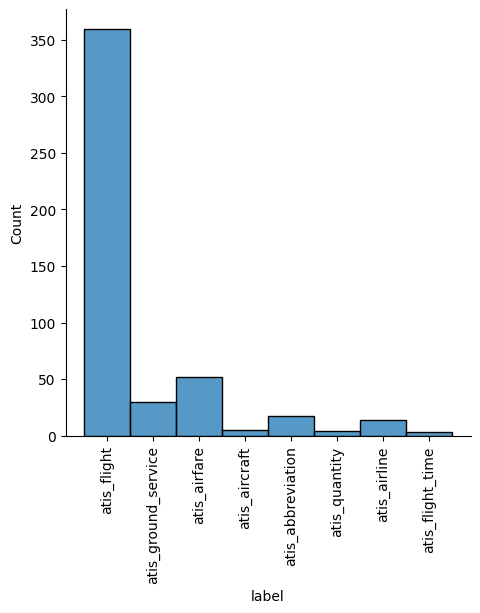

In [15]:
show_dist(atis_intent_val)

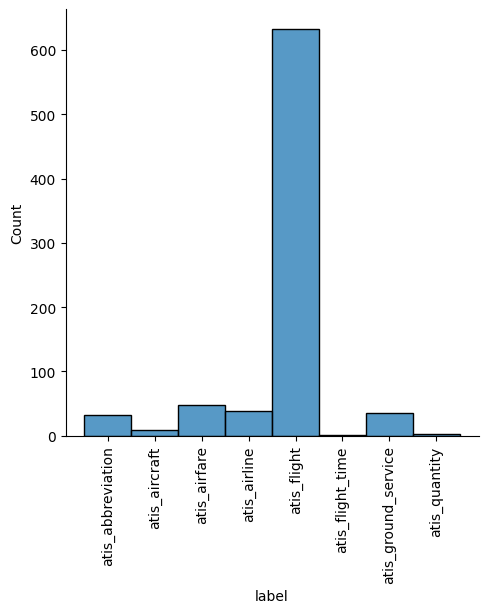

In [16]:
show_dist(atis_intent_test)

In [17]:
# convert labels to integers
def get_label_mapping(df:pd.DataFrame, mapping_dict: dict):
    unique_labels = df['label'].unique().tolist()
    label_mapping = mapping_dict

    # create labels maps
    numeric_list = [*map(label_mapping.get, df['label'].tolist())]
    df['num_label'] = numeric_list
    return df

In [18]:
unique_labels = atis_intent_train['label'].unique().tolist()
label_mapping = {x:i for i,x in enumerate(unique_labels)}
atis_intent_train = get_label_mapping(atis_intent_train,label_mapping)
atis_intent_val = get_label_mapping(atis_intent_val,label_mapping)
atis_intent_test = get_label_mapping(atis_intent_test,label_mapping)

In [24]:
i = 5
print(atis_intent_train[atis_intent_train['num_label'] == i]['label'].tolist()[0])
print(atis_intent_test[atis_intent_test['num_label'] == i]['label'].tolist()[0])

atis_flight_time
atis_flight_time


# Define Dataset Performance Metrics

In [25]:
import torch
from transformers import AutoTokenizer

class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# class ClassificationDataset(torch.utils.data.Dataset):
#     def __init__(self,
#                  csv_path:str,
#                  mode:str='train',
#                  model_id:str = 'albert-base-v2'):
#         self.mode = mode
#         self.df = pd.read_csv(csv_path, names=['label','text'])
#         self.model_id = model_id
#         # preprocess df to include numeric labels
#         self.get_label_mapping()
#         self.text,self.labels = self.preprocess()

#         # obtain labels and encodings
#         self.tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')
#         self.encodings = self.tokenize()
    

#     def tokenize(self):
#         train_text_encoded = self.tokenizer(self.text,padding=True,truncation=True, return_tensors='pt')
#         return train_text_encoded
    
#     def get_label_mapping(self) -> None:
#         unique_labels = self.df['label'].unique().tolist()
#         label_mapping = {x:i for i,x in enumerate(unique_labels)}

#         # create labels maps
#         numeric_list = [*map(label_mapping.get, self.df['label'].tolist())]
#         self.df['num_label'] = numeric_list

#     def preprocess(self) -> None:
#         self.unique_labels = self.df['num_label'].unique().tolist()
#         text = self.df['text'].tolist()
#         labels = self.df['num_label'].tolist()
#         return text, labels
    
#     def __len__(self):
#         return len(self.labels)
    
#     def __getitem__(self,idx) -> dict:
#         item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#         item['label'] = self.labels[idx]
#         return item
    
#     @property
#     def get_unique_labels(self):
#         return self.unique_labels

/opt/conda/envs/Monolith/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    """
    Dict containing the metrics to evaluate trained model
    on. Template and usage obtained from: https://huggingface.co/docs/transformers/training
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1_score_micro = f1_score(labels, preds, average='micro')
    f1_score_macro = f1_score(labels, preds, average='macro')
    return {
        'accuracy': acc,
        'f1_score_micro': f1_score_micro,
        'f1_score_macro': f1_score_macro
    }

In [27]:
label_names = atis_intent_train['num_label'].unique().tolist()

# texts
train_texts = atis_intent_train['text'].tolist()
dev_texts = atis_intent_val['text'].tolist()
test_texts = atis_intent_test['text'].tolist()

# labels
train_labels = atis_intent_train['num_label'].tolist()
dev_labels = atis_intent_val['num_label'].tolist()
test_labels = atis_intent_test['num_label'].tolist()

# Load Pretrained Model
For the puposes of this question, I will be using the library `transformers`. It offers multiple pre-trained models which are useful for transfer learning and it integrates well with PyTorch modules.
Reference Link: https://github.com/huggingface/transformers

The finetuning process is similar to the setup reccomended in the documentation: https://huggingface.co/docs/transformers/training

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')
model = AutoModelForSequenceClassification.from_pretrained('albert-base-v2',num_labels = len(label_names))

# load train and test datasets
train_dataset = ClassificationDataset('/home/ubuntu/adithya/temp/EAMLA/Natural Language Processing/atis_intents_train.csv')
val_dataset = ClassificationDataset('/home/ubuntu/adithya/temp/EAMLA/Natural Language Processing/atis_intents_test.csv')

# define training hyperparameters and trainer
training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=int(len(train_dataset)/16),
        weight_decay=0.01,
        logging_dir='./logs',
        evaluation_strategy="steps",
        eval_steps=50,
        save_steps=50,
        save_total_limit=10,
        load_best_model_at_end=True,
        no_cuda=False
    )

# define trainer
trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=train_dataset,
    )
trainer.train()
test_results = trainer.evaluate(val_dataset)
    
print(f"Final test accuracy:{test_results['eval_accuracy']}")

In [29]:
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification

# model_ids = ["prajjwal1/bert-tiny", "prajjwal1/bert-mini", 
#              "prajjwal1/bert-small", "prajjwal1/bert-medium",
#              "albert-base-v2", "albert-large-v2", "bert-base-uncased"]
model_ids = ["albert-base-v2"]

accuracies = []
for model_id in model_ids:
    
    print(f"*** {model_id} ***")

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=len(label_names))

    train_texts_encoded = tokenizer(train_texts,padding=True, truncation=True)
    dev_texts_encoded = tokenizer(dev_texts,padding=True, truncation=True)
    test_texts_encoded = tokenizer(test_texts,padding=True, truncation=True)
    
    train_dataset = ClassificationDataset(train_texts_encoded, train_labels)
    dev_dataset = ClassificationDataset(dev_texts_encoded, dev_labels)
    test_dataset = ClassificationDataset(test_texts_encoded, test_labels)
    
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=int(len(train_dataset)/16),
        weight_decay=0.01,
        logging_dir='./logs',
        evaluation_strategy="steps",
        eval_steps=50,
        save_steps=50,
        save_total_limit=10,
        load_best_model_at_end=True,
        no_cuda=False
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
    )

    trainer.train()
    test_results = trainer.evaluate(test_dataset)
    
    accuracies.append(test_results["eval_accuracy"])

In [30]:
accuracies

[0.9925]